## Import Libraries

Importing neccessary libraries for the code to run.

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import zipfile
import io
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from Bio import SeqIO
from Bio.PDB import PDBParser
from Bio.SeqUtils import ProtParamData, molecular_weight


In [ ]:
df = pd.read_json('data/thermomutdb.json')

print(df.shape)
print(df.columns.to_list())

cols_to_keep = [
    'PDB_wild',
    'protein',
    'ddg',
    'mutation_code',
    'pos',
    'mutation_type',
    'blosum62',
    'pam250',
    'ca_depth',
    'res_depth',
    'relative_bfactor',
    'phi',
    'psi',
    'sst',
    'rsa',
    'temperature',
    'ph',
]

df_filtered = df[cols_to_keep]
df_filtered.to_csv('data/thermomutdb_filtered.csv', index=False)
print(df_filtered.shape)
print(df_filtered.columns.tolist())


In [35]:
# Extract wild-type and mutant amino acids from mutation code
# "A45G" means residue A at position 45 mutated to G
df_filtered['wild_type'] = df_filtered['mutation_code'].str[0]
df_filtered['mutant'] = df_filtered['mutation_code'].str[-1]

# Missing values
print("\nMissing values in each column:")
print(df_filtered.isnull().sum())

# Handle missing values - fill with median for numerical columns
numerical_cols = ['blosum62', 'pam250', 'ca_depth', 'res_depth', 
                 'relative_bfactor', 'phi', 'psi', 'rsa', 
                 'temperature', 'ph', 'ddg']

for col in numerical_cols:
    if df_filtered[col].isnull().sum() > 0:
        df_filtered[col] = df_filtered[col].fillna(df_filtered[col].median())

# For categorical columns, fill with mode
categorical_cols = ['sst', 'mutation_type', 'wild_type', 'mutant']
for col in categorical_cols:
    if df_filtered[col].isnull().sum() > 0:
        df_filtered[col] = df_filtered[col].fillna(df_filtered[col].mode()[0])

# Drop any remaining rows with NaN values
df_filtered = df_filtered.dropna()
print(f"Dataset after handling missing values: {df_filtered.shape[0]} entries")

df_filtered.head(10)


Missing values in each column:
PDB_wild            0
protein             0
ddg                 0
mutation_code       0
pos                 0
mutation_type       0
blosum62            0
pam250              0
ca_depth            0
res_depth           0
relative_bfactor    0
phi                 0
psi                 0
sst                 0
rsa                 0
temperature         0
ph                  0
wild_type           0
mutant              0
dtype: int64
Dataset after handling missing values: 10153 entries


,PDB_wild,protein,ddg,mutation_code,pos,mutation_type,blosum62,pam250,ca_depth,res_depth,relative_bfactor,phi,psi,sst,rsa,temperature,ph,wild_type,mutant
0,1WQ5,Tryptophan synthase alpha chain,4.60,E49M,0.0,Single,-1.0,0.0,4.14,3.53,3.47,-118.5,113.0,Strand,0.00,298.95,7.0,E,M
1,1WQ5,Tryptophan synthase alpha chain,-2.50,E49Q,0.0,Single,-2.0,-2.0,4.14,3.53,3.47,-118.5,113.0,Strand,0.00,298.95,7.0,E,Q
2,2LZM,Endolysin,-1.71,W138Y,0.0,Single,1.0,1.0,2.00,3.85,2.70,-47.0,-54.4,AlphaHelix,0.05,298.15,2.2,W,Y
5,1TUP,Cellular tumor antigen p53,-3.07,C242S,0.0,Single,-1.0,0.0,2.00,2.64,3.35,-59.9,106.9,None,0.12,283.15,7.2,C,S
6,1TUP,Cellular tumor antigen p53,-4.78,F134L,0.0,Single,-2.0,-1.0,7.94,6.55,2.97,-115.6,128.7,Strand,0.00,283.15,7.2,F,L
7,1TUP,Cellular tumor antigen p53,-4.54,F270C,0.0,Single,-1.0,0.0,4.68,5.85,2.61,-150.7,150.2,Strand,0.01,283.15,7.2,F,C
8,1TUP,Cellular tumor antigen p53,-4.12,I195T,0.0,Single,-2.0,0.0,7.35,8.08,2.82,-106.1,126.9,Strand,0.06,283.15,7.2,I,T
9,1TUP,Cellular tumor antigen p53,-3.19,I232T,0.0,Single,-4.0,-3.0,3.90,4.81,2.77,-126.6,135.1,Strand,0.08,283.15,7.2,I,T
10,1TUP,Cellular tumor antigen p53,-3.29,I255F,0.0,Single,-1.0,0.0,7.27,7.07,2.75,-103.6,117.2,Strand,0.00,283.15,7.2,I,F
11,1TUP,Cellular tumor antigen p53,-2.98,L145Q,0.0,Single,-2.0,0.0,6.42,6.44,2.96,-97.0,128.5,Strand,0.03,283.15,7.2,L,Q


In [ ]:
print("\nBasic statistics for ddG:")
print(df_filtered['ddg'].describe())

# Visualize the distribution of ddG values
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered['ddg'], kde=True)
plt.title('Distribution of Protein Stability Changes (ddG)')
plt.xlabel('ddG (kcal/mol)')
plt.ylabel('Frequency')

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='wild_type', y='ddg', data=df_filtered)
plt.title('ddG Distribution by Wild Type Amino Acid')
plt.xlabel('Wild Type Amino Acid')
plt.ylabel('ddG (kcal/mol)')
plt.xticks(rotation=45)
plt.tight_layout()

In [ ]:

plt.figure(figsize=(12, 6))
sns.boxplot(x='mutant', y='ddg', data=df_filtered)
plt.title('ddG Distribution by Mutant Amino Acid')
plt.xlabel('Mutant Amino Acid')
plt.ylabel('ddG (kcal/mol)')
plt.xticks(rotation=45)
plt.tight_layout()

In [ ]:
correlation = df_filtered[numerical_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Between Features')
plt.tight_layout()

In [37]:
# One-hot encode categorical variables
df_encoded = df_filtered.copy()

# One-hot encode secondary structure (sst)
sst_dummies = pd.get_dummies(df_encoded['sst'], prefix='sst')
df_encoded = pd.concat([df_encoded, sst_dummies], axis=1)

# One-hot encode mutation type
mutation_type_dummies = pd.get_dummies(df_encoded['mutation_type'], prefix='mutation_type')
df_encoded = pd.concat([df_encoded, mutation_type_dummies], axis=1)

# One-hot encode wild-type and mutant amino acids
amino_acids = "ACDEFGHIKLMNPQRSTVWY"
for aa in amino_acids:
    df_encoded[f'wild_type_{aa}'] = (df_encoded['wild_type'] == aa).astype(int)
    df_encoded[f'mutant_{aa}'] = (df_encoded['mutant'] == aa).astype(int)

# Create physicochemical property changes
# Hydrophobicity values (Kyte-Doolittle scale)
hydrophobicity = {
    'A': 1.8, 'C': 2.5, 'D': -3.5, 'E': -3.5, 'F': 2.8, 'G': -0.4, 'H': -3.2,
    'I': 4.5, 'K': -3.9, 'L': 3.8, 'M': 1.9, 'N': -3.5, 'P': -1.6, 'Q': -3.5,
    'R': -4.5, 'S': -0.8, 'T': -0.7, 'V': 4.2, 'W': -0.9, 'Y': -1.3
}

# Volume values
volume = {
    'A': 88.6, 'C': 108.5, 'D': 111.1, 'E': 138.4, 'F': 189.9, 'G': 60.1, 'H': 153.2,
    'I': 166.7, 'K': 168.6, 'L': 166.7, 'M': 162.9, 'N': 114.1, 'P': 112.7, 'Q': 143.8,
    'R': 173.4, 'S': 89.0, 'T': 116.1, 'V': 140.0, 'W': 227.8, 'Y': 193.6
}

# Charge values
charge = {
    'A': 0, 'C': 0, 'D': -1, 'E': -1, 'F': 0, 'G': 0, 'H': 0.1, 'I': 0, 'K': 1,
    'L': 0, 'M': 0, 'N': 0, 'P': 0, 'Q': 0, 'R': 1, 'S': 0, 'T': 0, 'V': 0, 'W': 0, 'Y': 0
}

df_encoded['hydrophobicity_change'] = df_encoded.apply(
    lambda row: hydrophobicity.get(row['mutant'], 0) - hydrophobicity.get(row['wild_type'], 0), axis=1
)

df_encoded['volume_change'] = df_encoded.apply(
    lambda row: volume.get(row['mutant'], 0) - volume.get(row['wild_type'], 0), axis=1
)

df_encoded['charge_change'] = df_encoded.apply(
    lambda row: charge.get(row['mutant'], 0) - charge.get(row['wild_type'], 0), axis=1
)

# Drop original categorical columns that we've one-hot encoded
cols_to_drop = ['sst', 'mutation_type', 'wild_type', 'mutant', 'mutation_code', 'PDB_wild', 'protein']
df_encoded = df_encoded.drop(columns=cols_to_drop)

print(f"Dataset after feature engineering: {df_encoded.shape[1]} features")

df_encoded.head(10)

Dataset after feature engineering: 64 features


,ddg,pos,blosum62,pam250,ca_depth,res_depth,relative_bfactor,phi,psi,rsa,...,mutant_T,wild_type_V,mutant_V,wild_type_W,mutant_W,wild_type_Y,mutant_Y,hydrophobicity_change,volume_change,charge_change
0,4.60,0.0,-1.0,0.0,4.14,3.53,3.47,-118.5,113.0,0.00,...,0,0,0,0,0,0,0,5.4,24.5,1.0
1,-2.50,0.0,-2.0,-2.0,4.14,3.53,3.47,-118.5,113.0,0.00,...,0,0,0,0,0,0,0,0.0,5.4,1.0
2,-1.71,0.0,1.0,1.0,2.00,3.85,2.70,-47.0,-54.4,0.05,...,0,0,0,1,0,0,1,-0.4,-34.2,0.0
5,-3.07,0.0,-1.0,0.0,2.00,2.64,3.35,-59.9,106.9,0.12,...,0,0,0,0,0,0,0,-3.3,-19.5,0.0
6,-4.78,0.0,-2.0,-1.0,7.94,6.55,2.97,-115.6,128.7,0.00,...,0,0,0,0,0,0,0,1.0,-23.2,0.0
7,-4.54,0.0,-1.0,0.0,4.68,5.85,2.61,-150.7,150.2,0.01,...,0,0,0,0,0,0,0,-0.3,-81.4,0.0
8,-4.12,0.0,-2.0,0.0,7.35,8.08,2.82,-106.1,126.9,0.06,...,1,0,0,0,0,0,0,-5.2,-50.6,0.0
9,-3.19,0.0,-4.0,-3.0,3.90,4.81,2.77,-126.6,135.1,0.08,...,1,0,0,0,0,0,0,-5.2,-50.6,0.0
10,-3.29,0.0,-1.0,0.0,7.27,7.07,2.75,-103.6,117.2,0.00,...,0,0,0,0,0,0,0,-1.7,23.2,0.0
11,-2.98,0.0,-2.0,0.0,6.42,6.44,2.96,-97.0,128.5,0.03,...,0,0,0,0,0,0,0,-7.3,-22.9,0.0


In [38]:
# Define features and target
X = df_encoded.drop(columns=['ddg'])
y = df_encoded['ddg']

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Scale the numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Training set: 7107 samples
Validation set: 1523 samples
Test set: 1523 samples


In [41]:

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    
    Dense(16, activation='relu'),
    
    Dense(1)  # No activation for regression
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 128)               8192      
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

2025-03-23 12:56:12.186257: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [42]:
# Callbacks for better training
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('models/best_model.h5', save_best_only=True, monitor='val_loss')

history = model.fit(
    X_train_scaled, y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)


Epoch 1/200
223/223 [==============================] - 2s 4ms/step - loss: 3.4389 - mae: 1.2564 - val_loss: 2.9812 - val_mae: 1.1562
Epoch 2/200
223/223 [==============================] - 0s 2ms/step - loss: 3.0124 - mae: 1.1661 - val_loss: 2.7383 - val_mae: 1.1169
Epoch 3/200
223/223 [==============================] - 1s 2ms/step - loss: 2.8419 - mae: 1.1326 - val_loss: 2.6342 - val_mae: 1.0861
Epoch 4/200
223/223 [==============================] - 0s 2ms/step - loss: 2.7637 - mae: 1.1121 - val_loss: 2.5988 - val_mae: 1.0758
Epoch 5/200
223/223 [==============================] - 0s 2ms/step - loss: 2.6811 - mae: 1.0944 - val_loss: 2.6135 - val_mae: 1.0782
Epoch 6/200
223/223 [==============================] - 0s 2ms/step - loss: 2.6651 - mae: 1.0851 - val_loss: 2.5073 - val_mae: 1.0577
Epoch 7/200
223/223 [==============================] - 0s 2ms/step - loss: 2.6132 - mae: 1.0783 - val_loss: 2.4852 - val_mae: 1.0532
Epoch 8/200
223/223 [==============================] - 0s 2ms/step - 

In [45]:
# Load the best model
model = load_model('models/best_model.h5')

# Predictions on test set
y_pred = model.predict(X_test_scaled).flatten()

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R² Score: {r2:.4f}")


48/48 [==============================] - 0s 869us/step
Mean Squared Error: 2.8899
Root Mean Squared Error: 1.7000
Mean Absolute Error: 1.0527
R² Score: 0.3131


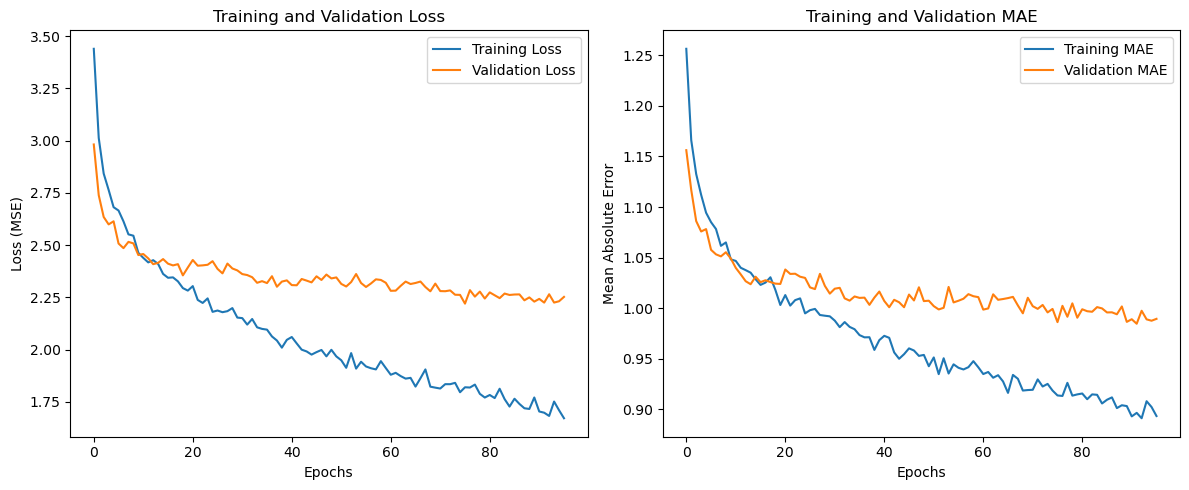

In [46]:
# Training history plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.title('Training and Validation MAE')
plt.legend()
plt.tight_layout()

Text(0.5, 1.0, 'Actual vs Predicted Protein Stability Changes')

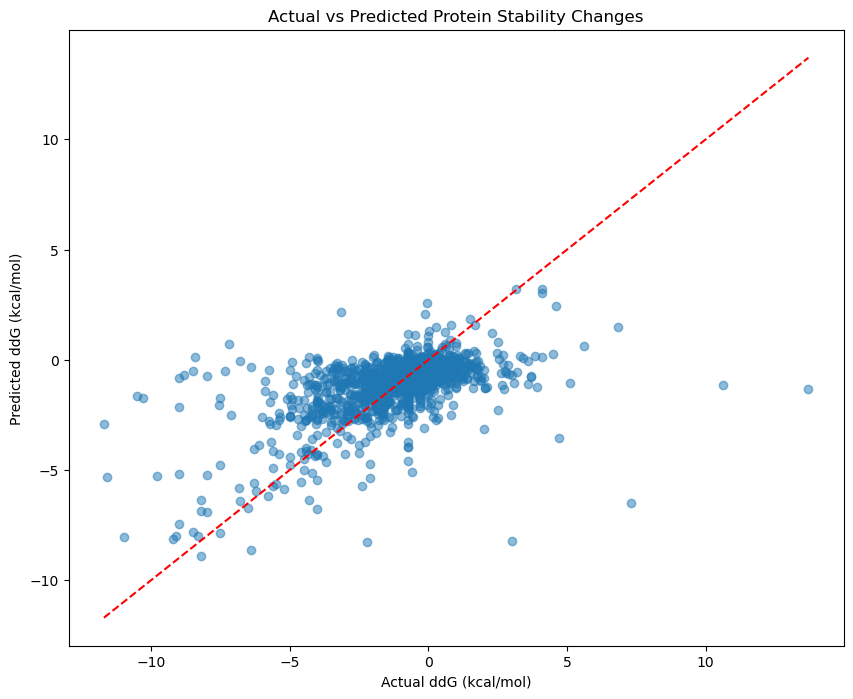

In [47]:
# Actual vs Predicted plot
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual ddG (kcal/mol)')
plt.ylabel('Predicted ddG (kcal/mol)')
plt.title('Actual vs Predicted Protein Stability Changes')

Text(0.5, 1.0, 'Distribution of Prediction Errors')

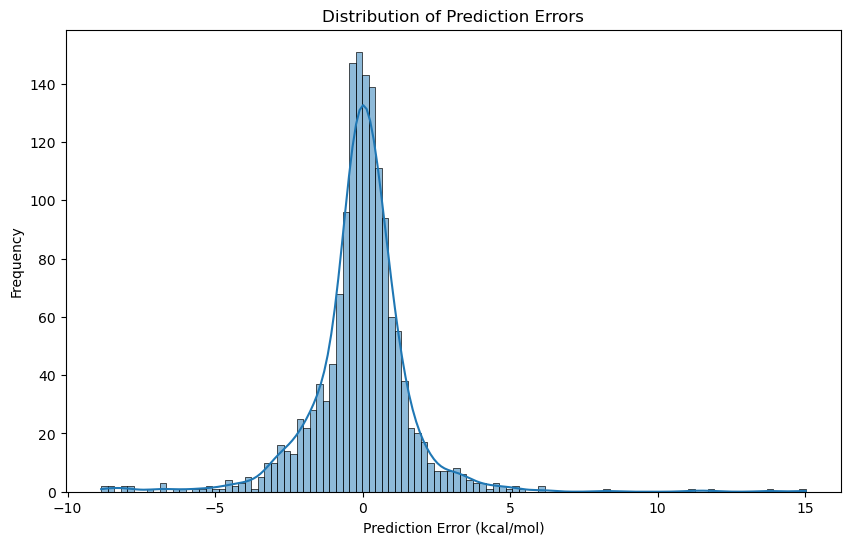

In [48]:
plt.figure(figsize=(10, 6))
errors = y_test - y_pred
sns.histplot(errors, kde=True)
plt.xlabel('Prediction Error (kcal/mol)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')

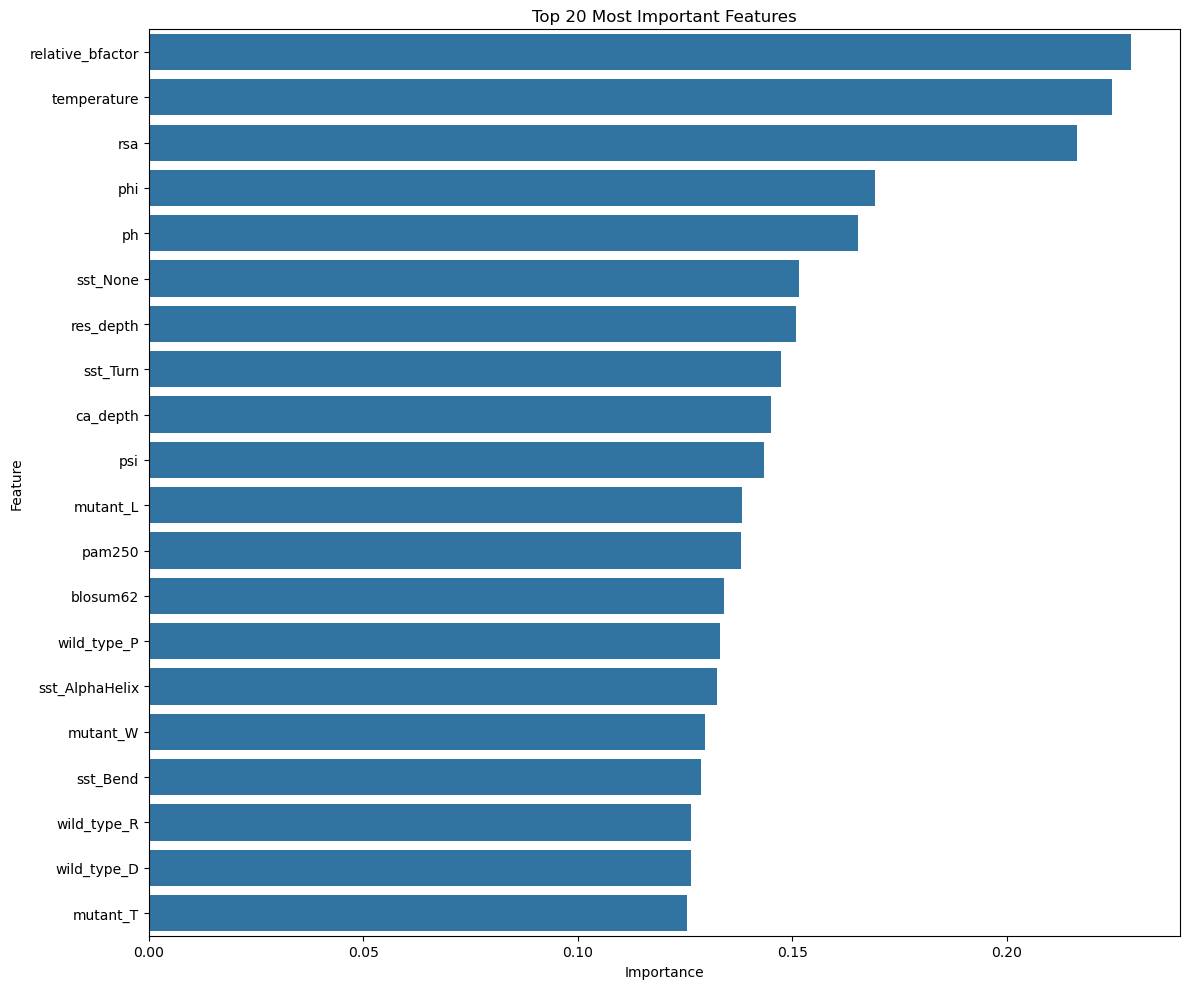

In [49]:
feature_importance = np.abs(model.layers[0].get_weights()[0]).mean(axis=1)
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Top 20 Most Important Features')
plt.tight_layout()